# Market Segmentation

In this notebook, we're looking at a dataset containing the usage behavior of about 9000 active credit cardholders during the last 6 months. Our goal is to use Unsupervised Learning in order to create clusters of credit cardholders with similar behaviors. Such a task might be required to identify potential customers for an insurance company, for example. 

Let's start by importing the necessary libraries.

In [1]:
import csv
import os
import time
import pandas as pd
import numpy as np
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.tree import DecisionTreeClassifier

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline

### Data exploration

At first, we will get a look at the content of our data. The dataset contains 18 features, one being the ID of the customer and the rest describing the behaviours of said customer.<br>

**CUST_ID** :Customer ID.<br>
**BALANCE** :Amount of money currently owed by the cardholder.<br>
**BALANCE_FREQUENCY** :How frequently the balance is updated, possibly indicating how active the account is.<br>
**PURCHASES** :Total spending on purchases.<br>
**ONEOFF_PURCHASES** :Total spending on single-instance purchases not part of an installment plan.<br>
**INSTALLMENTS_PURCHASES** :Total spending on purchases made in installments.<br>
**CASH_ADVANCE** :Total cash withdrawn on the credit card.<br>
**PURCHASES_FREQUENCY** :How frequently purchases are made.<br>
**ONEOFF_PURCHASES_FREQUENCY** :How frequently one-off purchases are made.<br>
**PURCHASES_INSTALLMENTS_FREQUENCY** :How frequently purchases are made in installments.<br>
**CASH_ADVANCE_FREQUENCY** :How frequently cash advances are taken.<br>
**CASH_ADVANCE_TRX** :Number of transactions involving cash advances.<br>
**PURCHASES_TRX** :Number of purchase transactions.<br>
**CREDIT_LIMIT** :Maximum credit amount available to the cardholder.<br>
**PAYMENTS** :Total payments made by the cardholder.<br>
**MINIMUM_PAYMENTS** :Minimum amount the cardholder is required to pay.<br>
**PRC_FULL_PAYMENT** :Percentage of the total due amount paid by the cardholder.<br>
**TENURE** :Length of time the credit card account has been active.<br>

In [4]:
df = pd.read_csv("Customer_Data.csv")

In [5]:
df.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


### Cleaning the dataset

We search for columns with NaN values and replace these NaN values by the median of their associated column

In [6]:
col_nan = list(df.columns[df.isna().any()])
print(f"Columns with NaN values: {col_nan}")
for c in col_nan:
    median_value = df[c].median()
    df[c].fillna(median_value, inplace=True)

Columns with NaN values: ['CREDIT_LIMIT', 'MINIMUM_PAYMENTS']


### Numerical statistics

In [7]:
numerical_cols = list(df.select_dtypes(include=['number']).columns)
non_numerical_cols = list(df.select_dtypes(exclude=['number']).columns)
print(f"Non numerical columns: {non_numerical_cols}")

Non numerical columns: ['CUST_ID']


In [8]:
d = df.drop(columns=['CUST_ID'])

infos_data = {
    'Column': [],
    'Type': [],
    'Min' : [],
    'Max' : [],
    'Mean' : [],
    'Std' : [],
    'Median' : [],
    '25%' : [],
    '50%' : [],
    '75%' : []
}

for c in d.columns:
    infos_data['Column'].append(c)
    infos_data['Type'].append(d[c].dtype)
    infos_data['Min'].append(min(d[c]))
    infos_data['Max'].append(max(d[c]))
    infos_data['Mean'].append(statistics.mean(list(d[c])))
    infos_data['Std'].append(statistics.pstdev(list(d[c])))
    infos_data['Median'].append(statistics.median(list(d[c])))
    infos_data['25%'].append(np.quantile(d[c], 0.25))
    infos_data['50%'].append(np.quantile(d[c], 0.50)),
    infos_data['75%'].append(np.quantile(d[c], 0.75))

infos_df = pd.DataFrame(infos_data)

In [9]:
pd.DataFrame.from_dict(infos_data)

,Column,Type,Min,Max,Mean,Std,Median,25%,50%,75%
0,BALANCE,float64,0.000000,19043.13856,1564.474828,2081.415590,873.385231,128.281915,873.385231,2054.140036
1,BALANCE_FREQUENCY,float64,0.000000,1.00000,0.877271,0.236891,1.000000,0.888889,1.000000,1.000000
2,PURCHASES,float64,0.000000,49039.57000,1003.204834,2136.515413,361.280000,39.635000,361.280000,1110.130000
3,ONEOFF_PURCHASES,float64,0.000000,40761.25000,592.437371,1659.795184,38.000000,0.000000,38.000000,577.405000
4,INSTALLMENTS_PURCHASES,float64,0.000000,22500.00000,411.067645,904.287592,89.000000,0.000000,89.000000,468.637500
5,CASH_ADVANCE,float64,0.000000,47137.21176,978.871112,2097.046713,0.000000,0.000000,0.000000,1113.821139
6,PURCHASES_FREQUENCY,float64,0.000000,1.00000,0.490351,0.401348,0.500000,0.083333,0.500000,0.916667
7,ONEOFF_PURCHASES_FREQUENCY,float64,0.000000,1.00000,0.202458,0.298319,0.083333,0.000000,0.083333,0.300000
8,PURCHASES_INSTALLMENTS_FREQUENCY,float64,0.000000,1.00000,0.364437,0.397426,0.166667,0.000000,0.166667,0.750000
9,CASH_ADVANCE_FREQUENCY,float64,0.000000,1.50000,0.135144,0.200110,0.000000,0.000000,0.000000,0.222222


Let's select a sample of three random customers in this dataset and let's try to come up with the type of behavioral subgroup they may end up in regarding the insurance company we're working for.

In [10]:
customer_ids = ["C10004", "C10002", "C10007"]
customer_rows = df[df['CUST_ID'].isin(customer_ids)]
customer_rows

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
1,C10002,3202.467416,0.909091,0.00,0.00,0.00,6442.945483,0.000000,0.000000,0.0,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.00,205.788017,0.083333,0.083333,0.0,0.083333,1,1,7500.0,0.000000,312.343947,0.000000,12
6,C10007,627.260806,1.000000,7091.01,6402.63,688.38,0.000000,1.000000,1.000000,1.0,0.000000,0,64,13500.0,6354.314328,198.065894,1.000000,12


- **C10002** : This customer has pretty high values for **CASH_ADVANCE** and **CASH_ADVANCE_FREQUENCY**. We can see that it is probably a customers who frequently uses cash advances and may be in need of short-term liquidity. A potential product that may appeal to similar customers would be short-term loan offers or overdraft protection.
- **C10004** : This customer has an above-average value for **PURCHASE** but also a low value for **PRC_FULL_PAYMENT**. It might mean that such customers spend a lot but don’t pay their balance in full, suggesting they could benefit from products that help manage debt or reduce interest rates.
- **C10007** : This customer has a low **BALANCE** but a high **CREDIT_LIMIT**. Typically, such customers may have surplus income or savings, making them good candidates for investment advice or upselling higher-tier credit products with additional benefits.

### Data Distribution

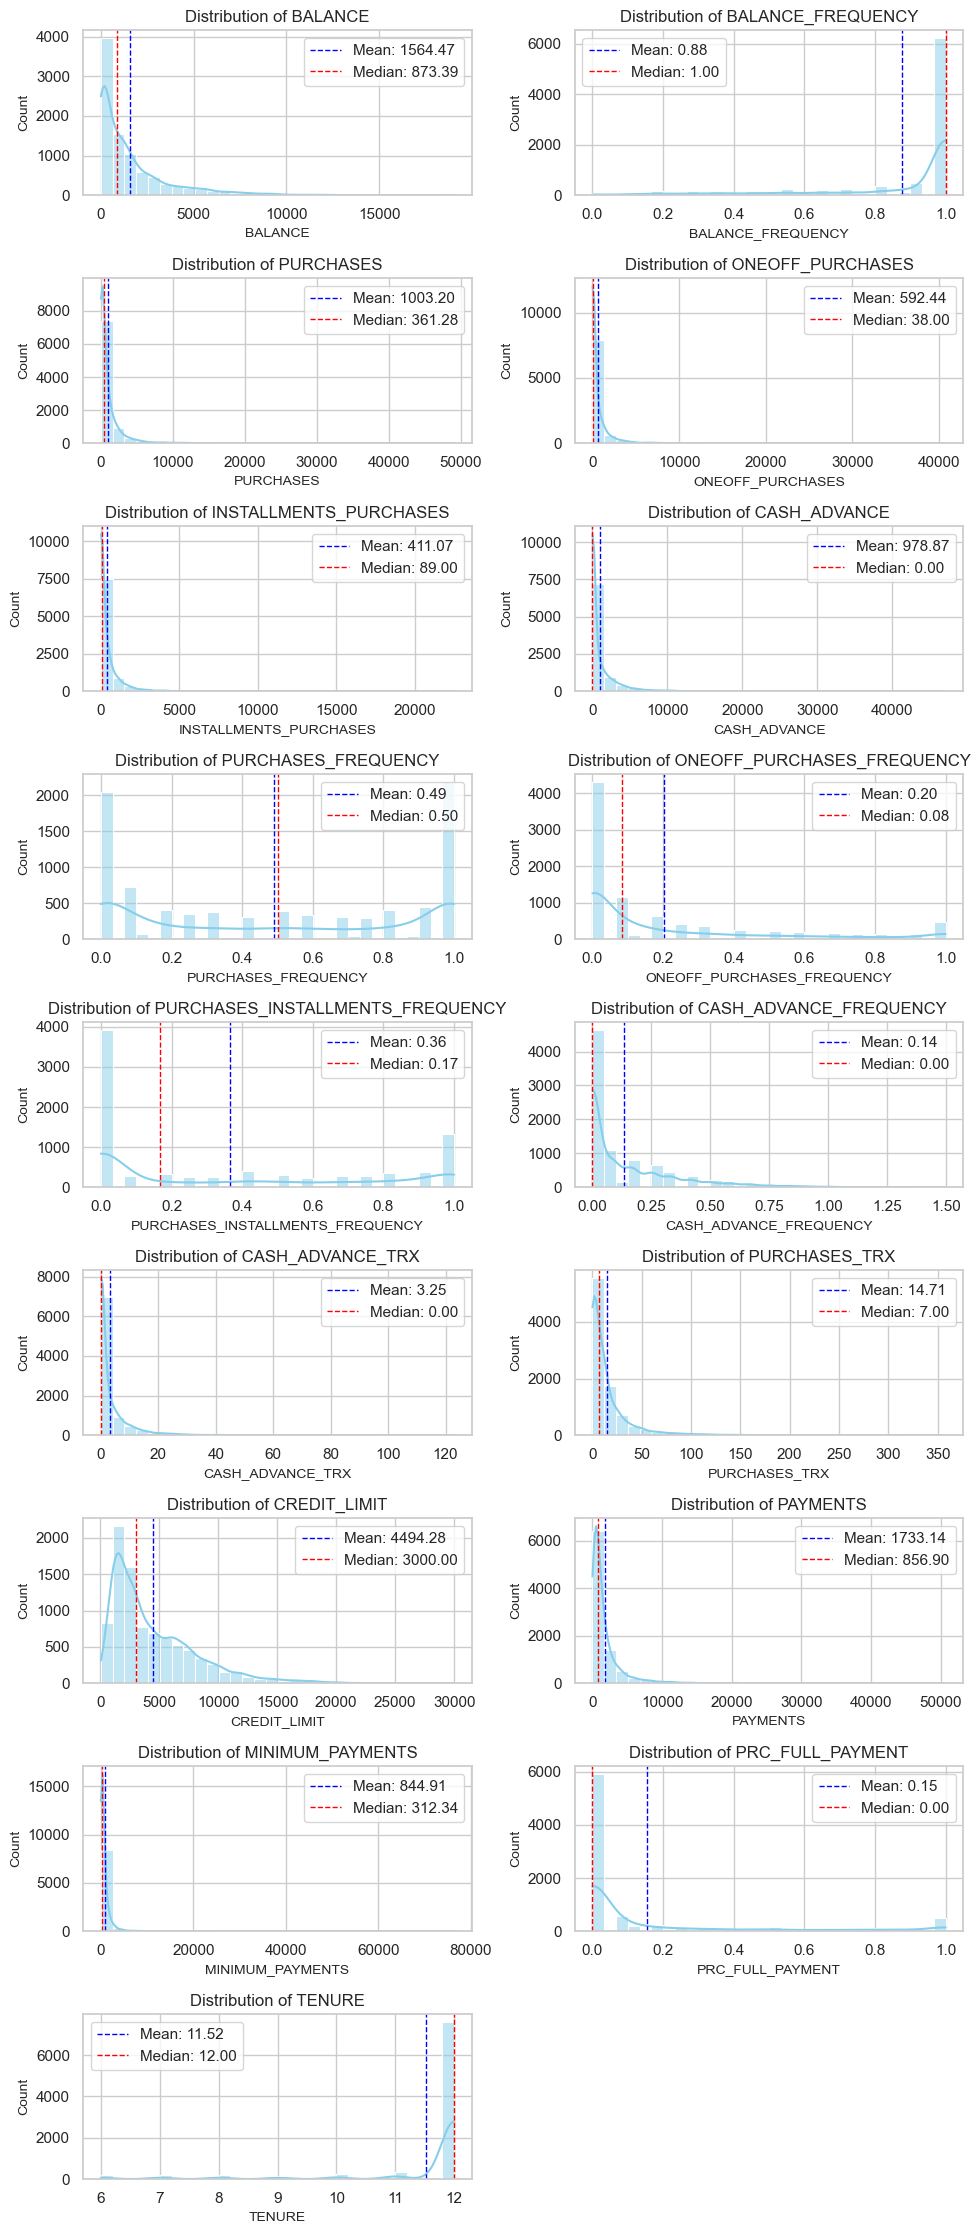

In [11]:
sns.set(style='whitegrid')

n_cols = 2
n_rows = (len(d.columns) + 1) // n_cols
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(10, 2.5 * n_rows))
axes = axes.flatten()

for idx, col in enumerate(d.columns):
    ax = axes[idx]
    sns.histplot(d[col], bins=30, kde=True, color="skyblue", ax=ax)
    mean_val = d[col].mean()
    median_val = d[col].median()
    ax.axvline(mean_val, color="blue", linestyle="dashed", linewidth=1, label=f"Mean: {mean_val:.2f}")
    ax.axvline(median_val, color="red", linestyle="dashed", linewidth=1, label=f"Median: {median_val:.2f}")
    ax.legend()
    ax.set_title(f"Distribution of {col}")
    ax.set_xlabel(col, fontsize=10)
    ax.set_ylabel("Count", fontsize=10)

plt.tight_layout()
for idx in range(len(d.columns), n_cols * n_rows):
    fig.delaxes(axes[idx])

plt.show()

### Features Correlation

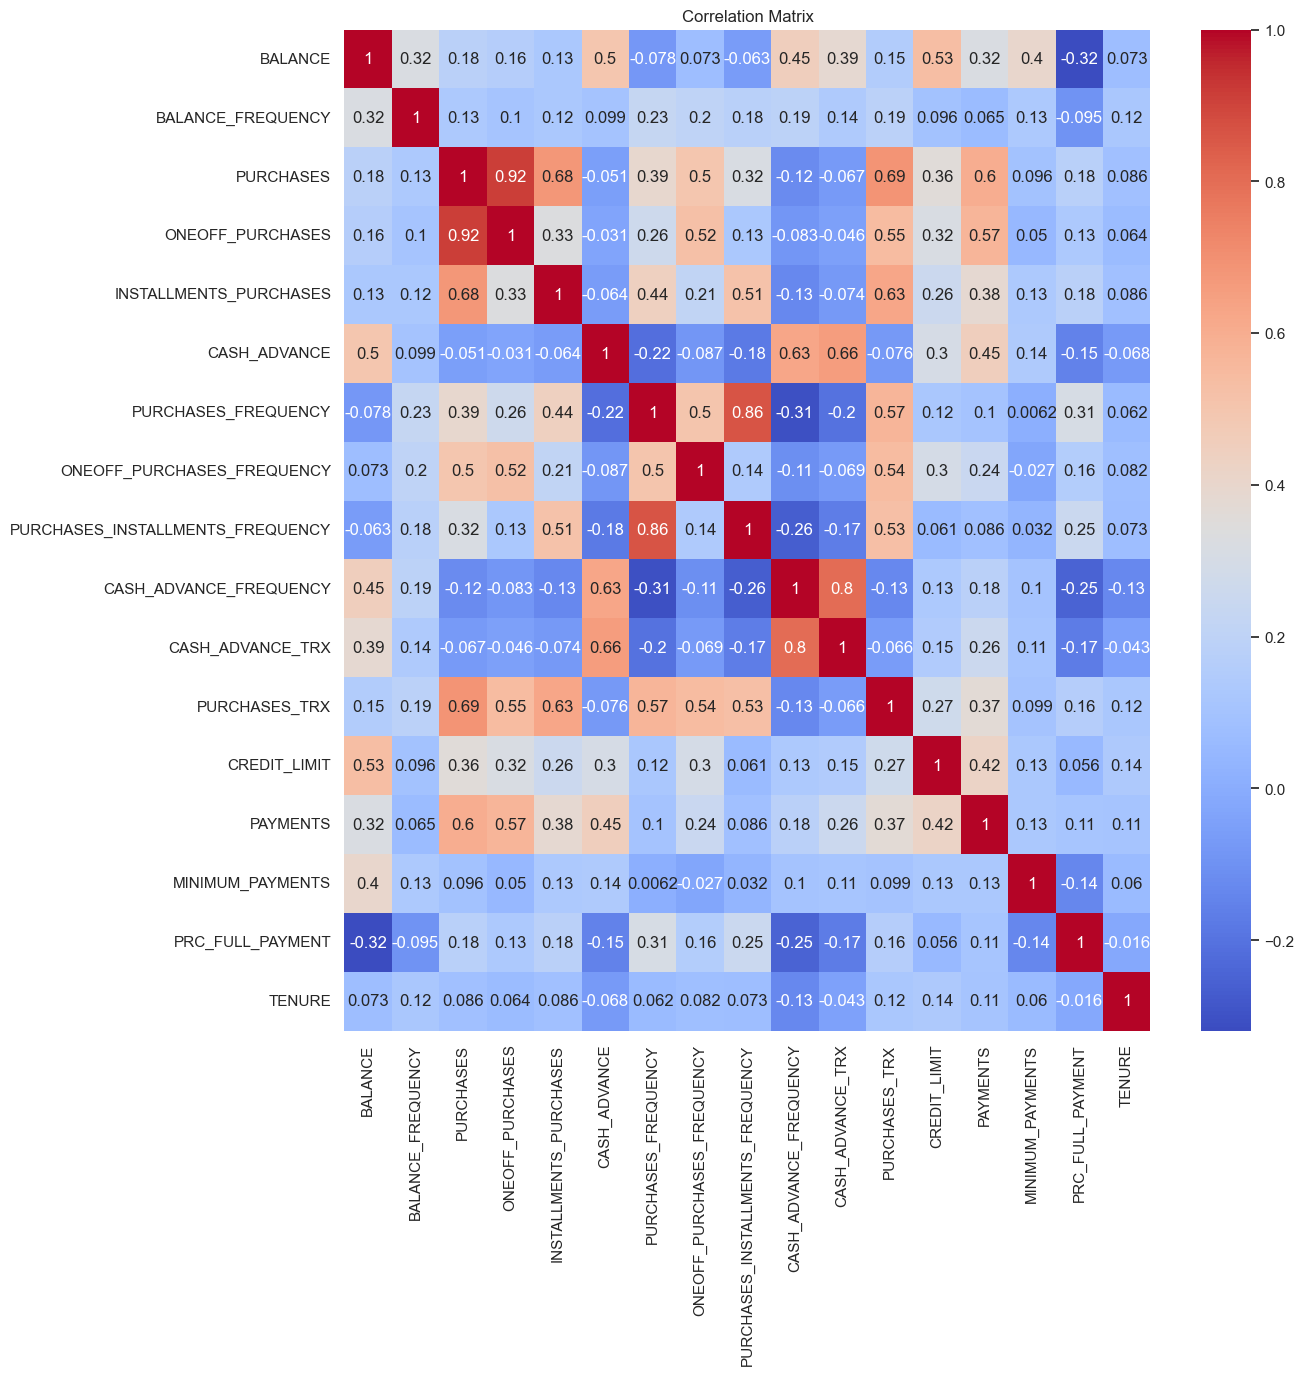

In [12]:
corr = d.corr()

plt.figure(figsize=(13,13))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

### Clustering

In [13]:
# X = d.values

# X_train, X_test = train_test_split(X, train_size=0.9, shuffle=True, random_state=42)
# print(np.shape(X_train), np.shape(X_test))

(8055, 17) (895, 17)


In [31]:
X_train = d.values
print(np.shape(X_train))

(8950, 17)


We will now train clustering algorithms on our data and determine patterns through which the dataset can be divided in subgroups.

#### K-Means

The K-Means clustering algorithm aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean (cluster centers or cluster centroid), serving as a prototype of the cluster. <br>
The elbow method is a popular technique to determine the optimal number of clusters for KMeans clustering. It involves plotting the sum of squared distances of samples to their closest cluster center for different numbers of clusters

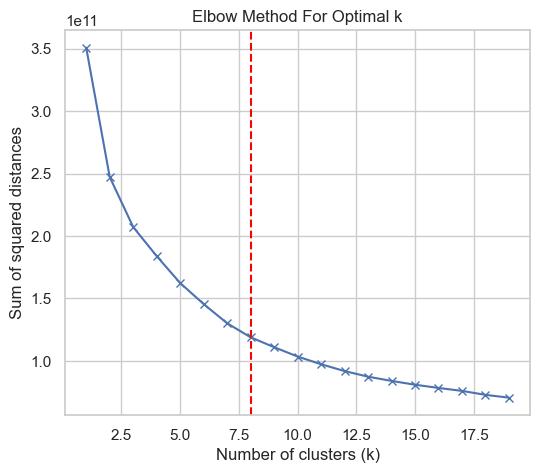

In [14]:
sum_of_squared_distances = []
K = range(1, 20)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X_train)
    sum_of_squared_distances.append(km.inertia_)

plt.figure(figsize=(6, 5))
plt.plot(K, sum_of_squared_distances, "bx-")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Sum of squared distances")
plt.title("Elbow Method For Optimal k")
plt.axvline(x=8, color="red", linestyle="--")
plt.show()

In [15]:
kmeans = KMeans(n_clusters=8, random_state=42).fit(X_train)

Principal Component Analysis (PCA) is a statistical technique used for dimensionality reduction while preserving as much variance (information) as possible. It is a good way to visualize the clusters created by our KMeans algorithm.

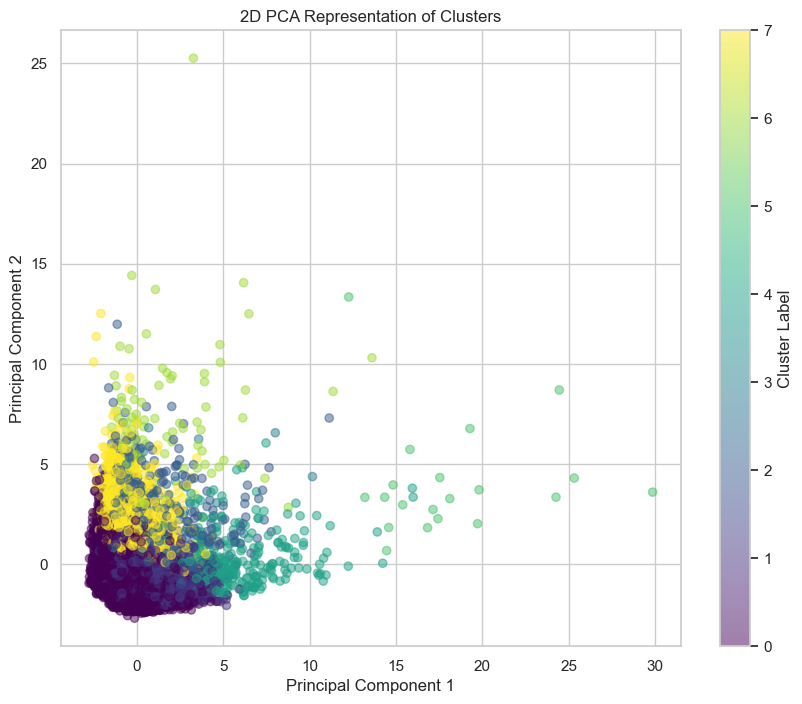

In [16]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

cluster_labels = kmeans.labels_

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap="viridis", alpha=0.5)
plt.title("Representation of Clusters")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(scatter, label="Cluster Label")
plt.grid(True)
plt.show()

Even after PCA, our data points are still grouped together. It might be a good idea to train the KMeans algorithm on a dataset with a lower dimensionality. However, rather than sticking to PCA, we'll use t-SNE (t-Distributed Stochastic Neighbor Embedding). Unlike PCA, which is linear, t-SNE handles complex structures by capturing non-linear relationships.

In [32]:
tsne = TSNE(n_components=2, init="random", learning_rate="auto", random_state=42)
X_tsne = tsne.fit_transform(X_train)

In [33]:
kmeans = KMeans(n_clusters=8, random_state=42).fit(X_tsne)

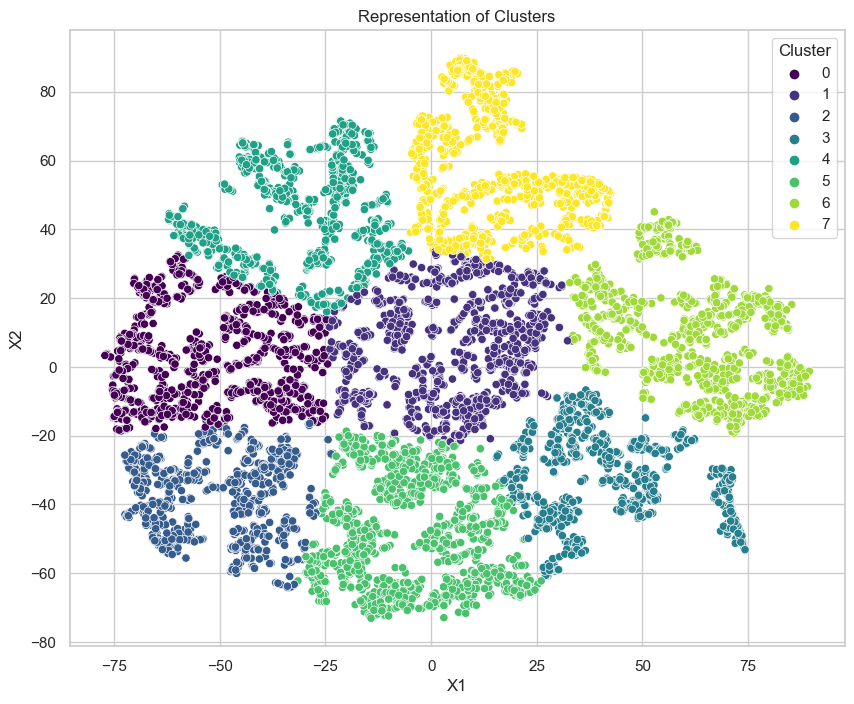

In [34]:
cluster_labels = kmeans.labels_

plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=cluster_labels, palette='viridis', legend='full')
plt.title('Representation of Clusters')
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend(title='Cluster', loc='upper right')
plt.grid(True)
plt.show()

We can now trace back the relevance and distribution of each feature in each cluster. <br>
First, we need to attach the cluster labels from our KMeans model trained on the t-SNE reduced data back to the original dataset. <br>
Examining the statistical properties (such as the mean value, as illustrated below) of each feature within each cluster can help identify which features have distinct values across different clusters.

In [38]:
d_clusters = d.copy()
d_clusters['cluster'] = kmeans.labels_

cluster_means = d_clusters.groupby('cluster').mean()
cluster_means

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
cluster,,,,,,,,,,,,,,,,,
0,664.832210,0.854062,1230.150569,691.236851,539.583805,102.583124,0.668368,0.330842,0.478377,0.030118,0.584987,20.626402,5766.726802,1156.021687,288.196491,0.263895,11.838654
1,1058.914347,0.886076,704.261904,487.329332,217.018261,1128.372975,0.386937,0.212119,0.234426,0.183141,4.421270,10.458368,2641.987726,2294.998284,498.143639,0.131596,11.590272
2,1399.651445,0.906329,4252.248896,2905.330248,1347.649505,303.865559,0.785269,0.553523,0.566599,0.043136,1.027027,45.161036,9701.801802,4194.187320,707.969704,0.341793,11.837838
3,2396.691710,0.945353,286.689876,127.781672,158.942601,1360.303020,0.263378,0.080785,0.192204,0.236718,5.301342,6.163055,3270.072239,784.130247,2695.704270,0.004160,11.337461
4,226.737126,0.737012,588.760402,186.045916,402.761009,56.288191,0.566178,0.115891,0.472236,0.019821,0.324192,11.084231,3113.783328,630.890065,183.965132,0.258554,11.708129
5,4917.234007,0.958963,889.029740,541.882287,347.213489,3779.759234,0.390774,0.202697,0.272599,0.335252,9.594655,13.952487,9026.803671,3786.316814,1636.769156,0.029018,11.648107
6,1052.132073,0.931808,250.447315,91.238472,159.571031,395.558900,0.312126,0.086853,0.233065,0.150889,2.688189,5.906299,1332.283465,544.500811,630.341730,0.013791,11.291339
7,175.937929,0.774174,487.676851,157.475162,330.688578,31.536676,0.638293,0.092133,0.543116,0.019713,0.293629,10.502308,1404.693752,432.032630,175.200931,0.260513,10.912281


A practical approach to find which features best separate the clusters is to use a supervised method like a decision tree, where the features are our original dataset and the target is the cluster labels.

In [39]:
X = d_clusters.drop("cluster", axis=1)
y = d_clusters["cluster"]

tree = DecisionTreeClassifier(random_state=42)
tree.fit(X, y)

importance = pd.DataFrame(tree.feature_importances_, index=X.columns, columns=["importance"]).sort_values("importance", ascending=False)
print(importance)

                                  importance
CREDIT_LIMIT                        0.328835
BALANCE                             0.233509
PAYMENTS                            0.162897
PURCHASES                           0.073676
CASH_ADVANCE                        0.067162
MINIMUM_PAYMENTS                    0.054956
INSTALLMENTS_PURCHASES              0.026204
ONEOFF_PURCHASES                    0.019997
CASH_ADVANCE_FREQUENCY              0.007863
PURCHASES_TRX                       0.006972
CASH_ADVANCE_TRX                    0.004322
PURCHASES_FREQUENCY                 0.004154
ONEOFF_PURCHASES_FREQUENCY          0.002959
BALANCE_FREQUENCY                   0.002324
PURCHASES_INSTALLMENTS_FREQUENCY    0.002043
PRC_FULL_PAYMENT                    0.001182
TENURE                              0.000945


It is also possible to visualize the distribution of each feature within each cluster using box plots.

For example, we can see below that the cluster 5 groups customers with a higher **BALANCE** that the other clusters. 
Similarily, cluster 5 gathers customers with high **CASH_ADVANCE** and high **CASH_ADVANCE_FREQUENCY** which is one of the many possible combinations of features we highlighted previously in this notebook.

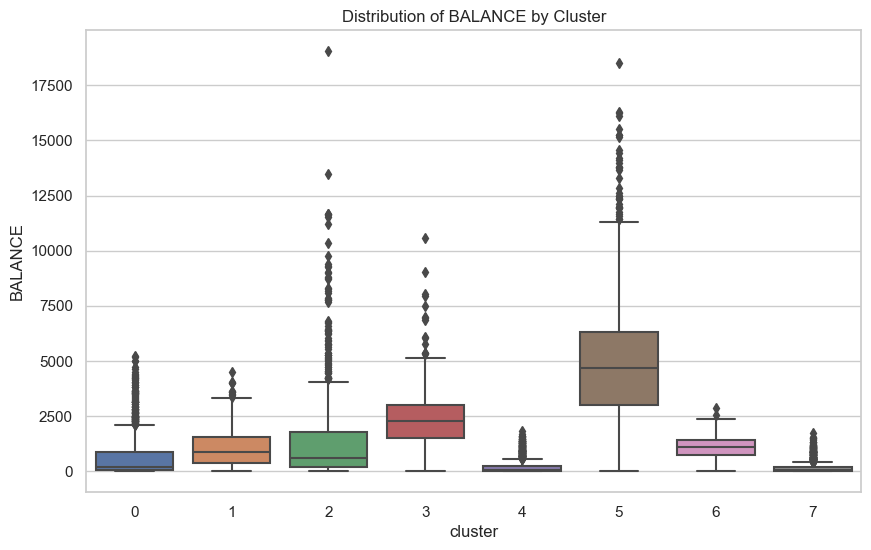

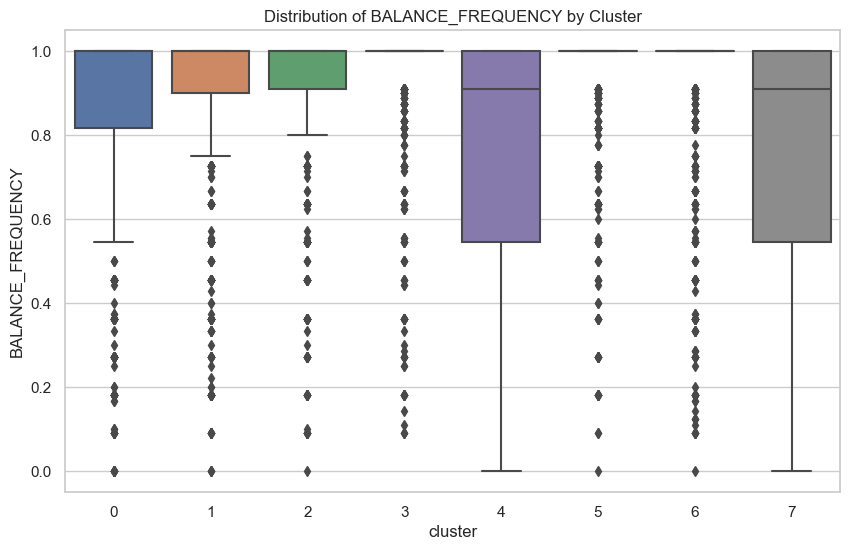

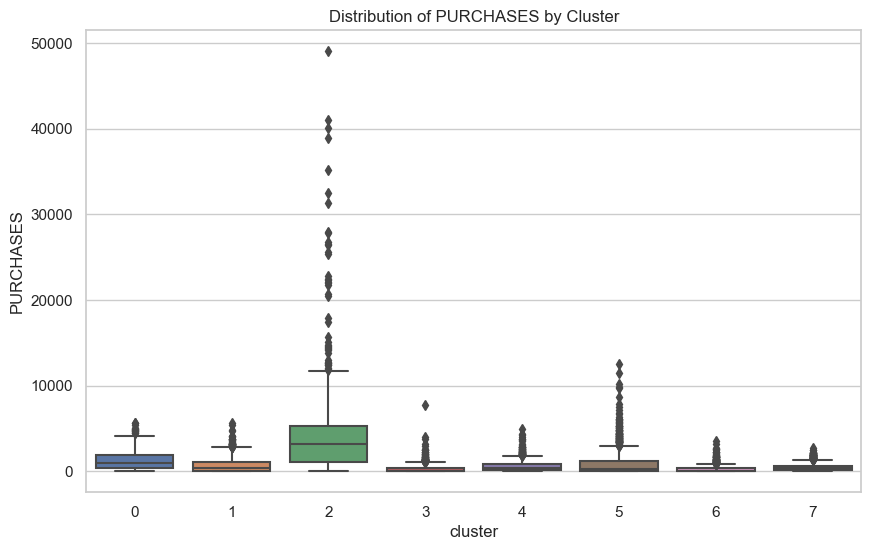

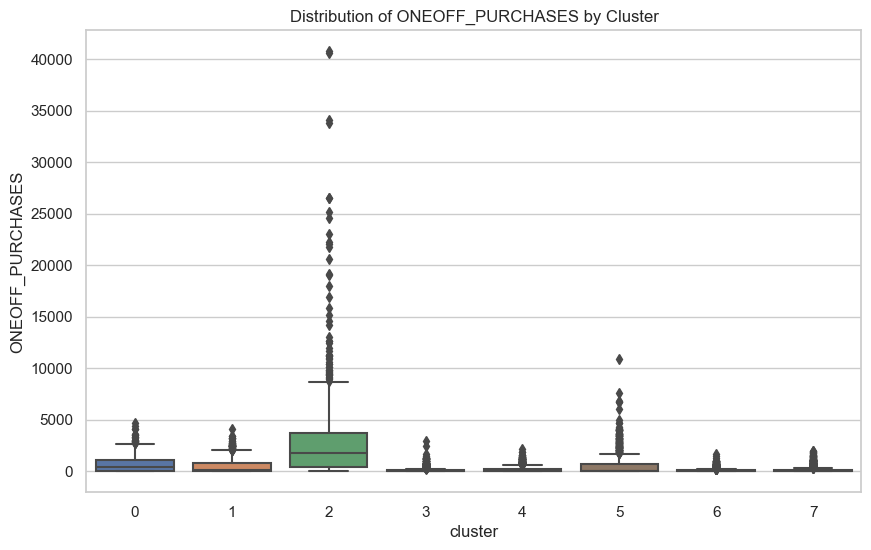

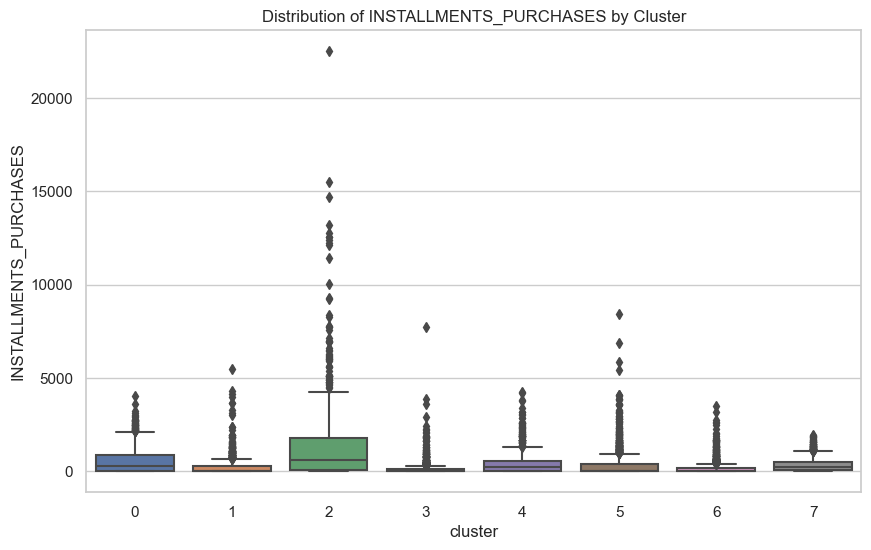

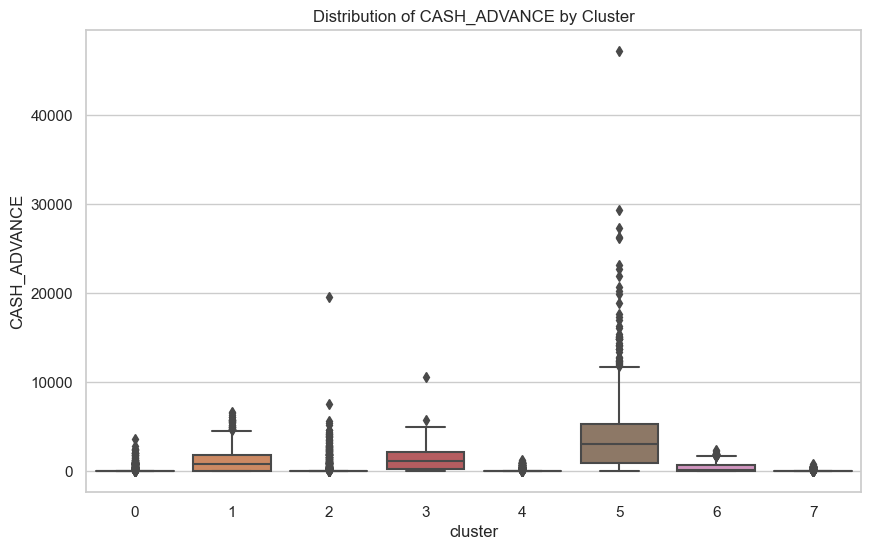

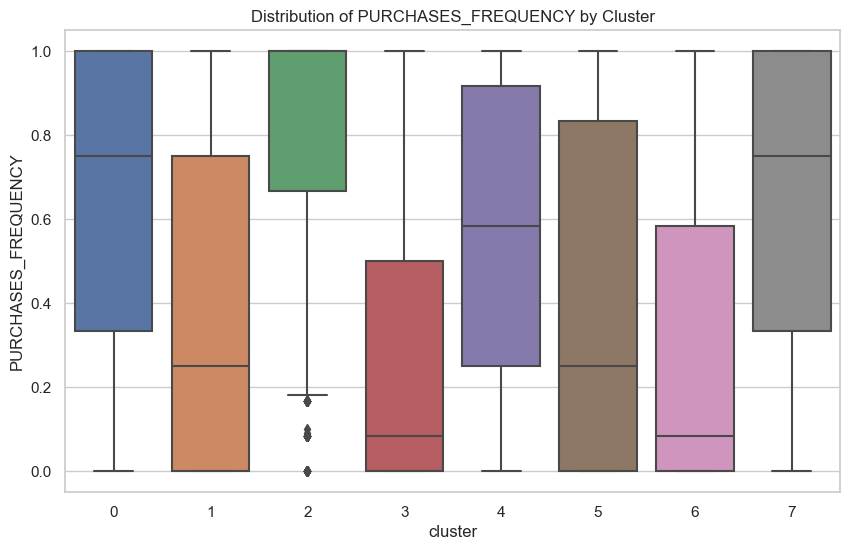

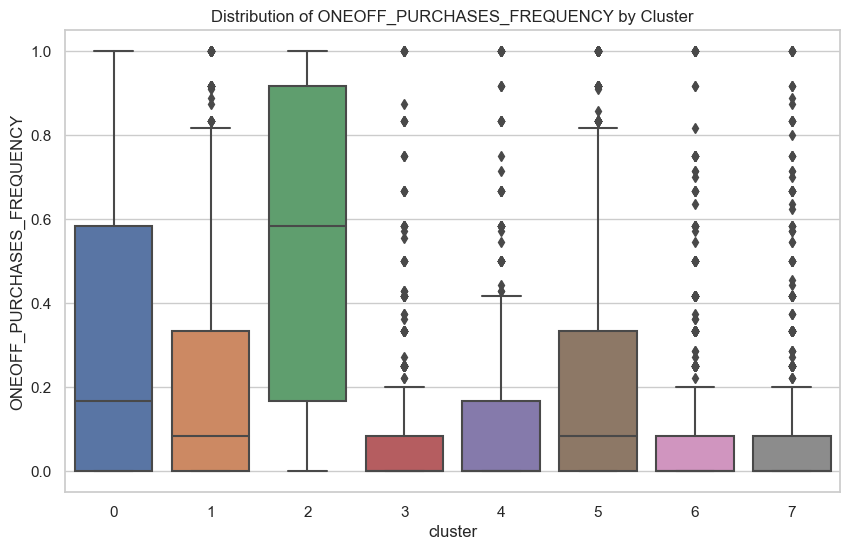

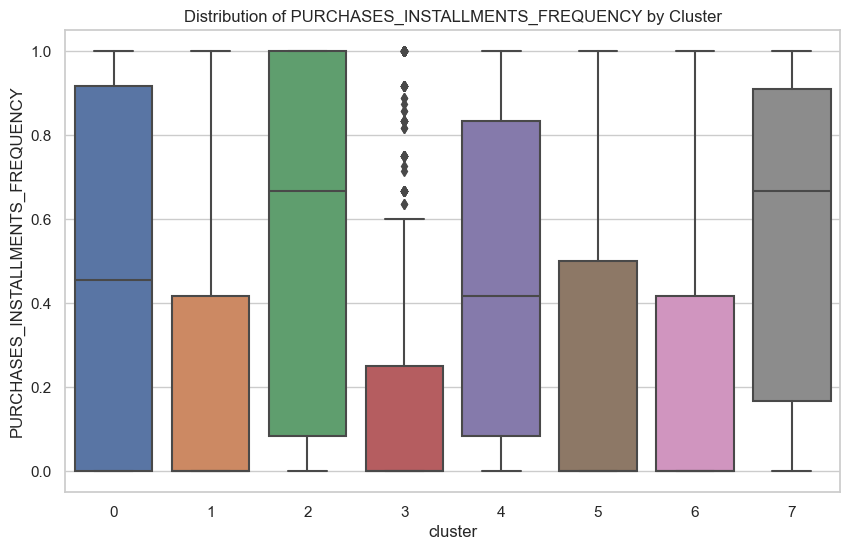

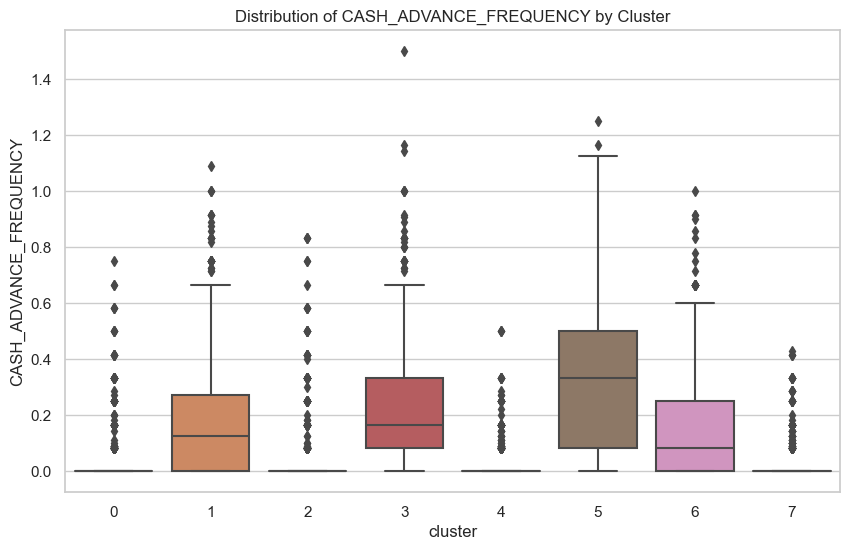

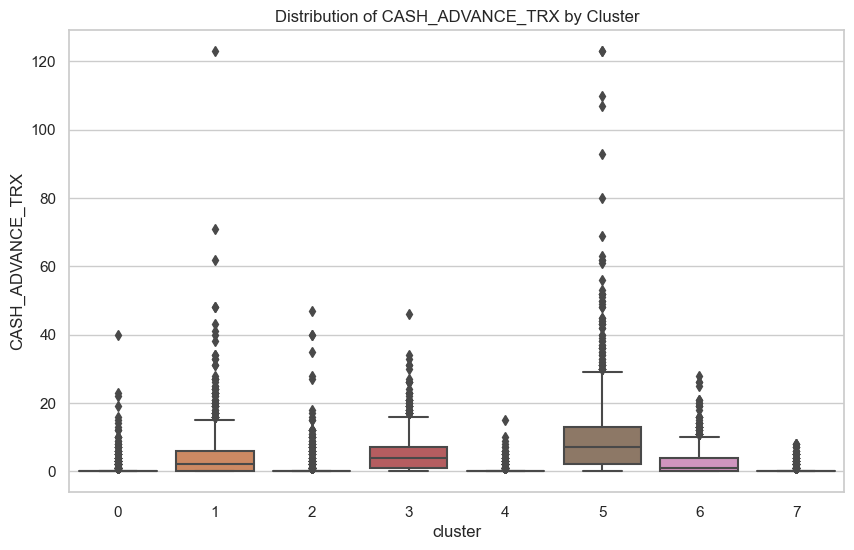

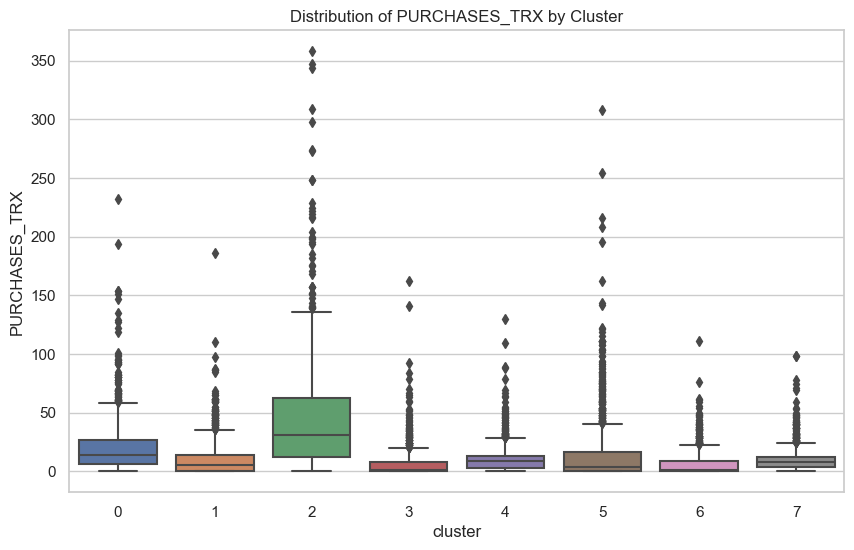

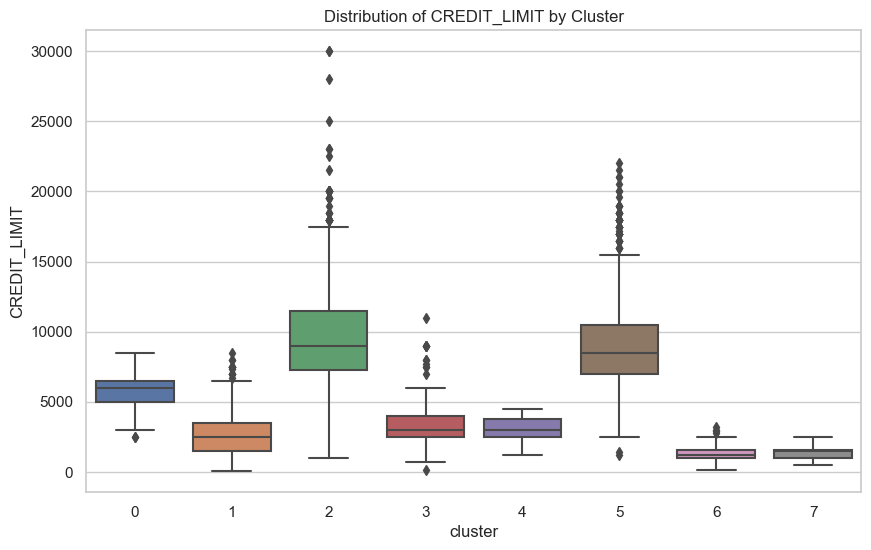

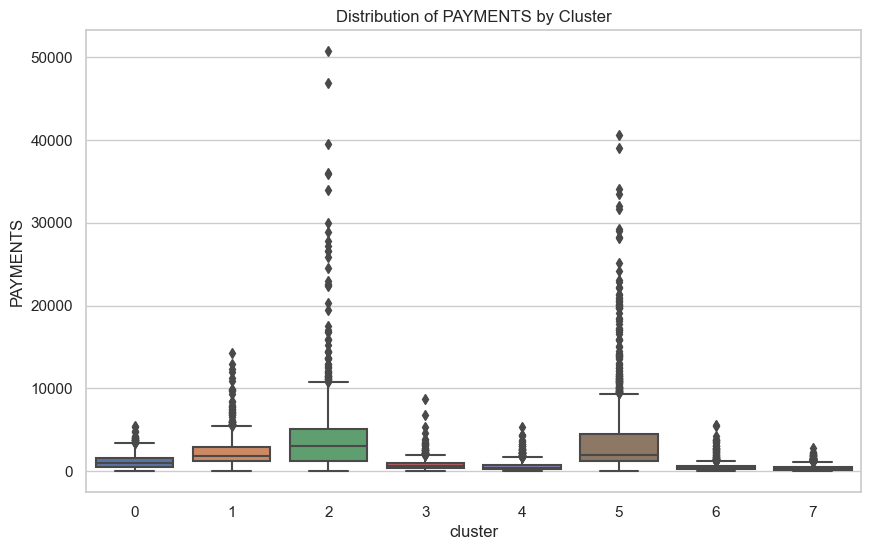

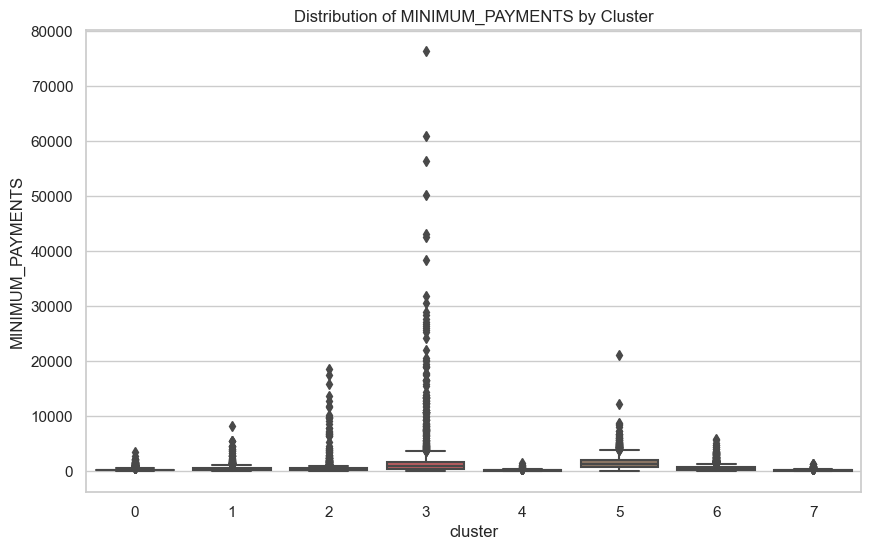

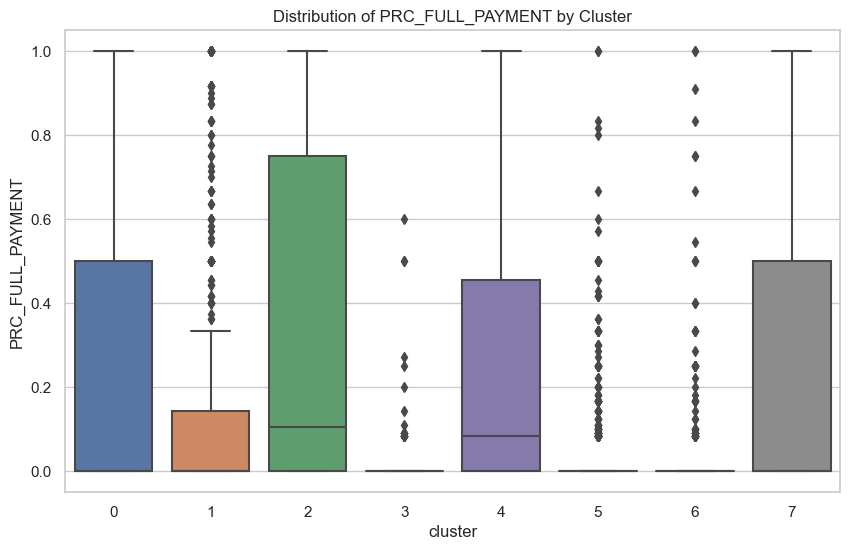

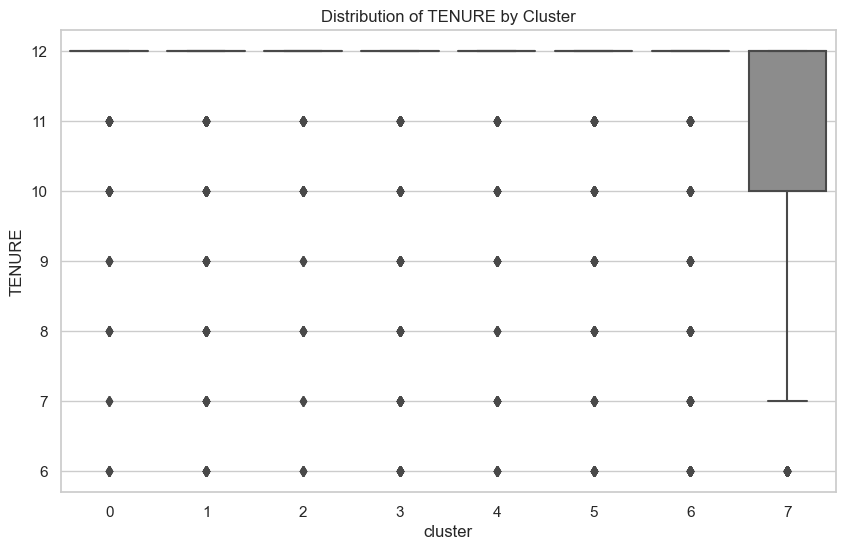

In [42]:
for feature in X.columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='cluster', y=feature, data=d_clusters)
    plt.title(f'Distribution of {feature} by Cluster')
    plt.show()